In [1]:
import numpy as np
from matplotlib import pyplot as plt
from DS_detector import clusters_in_pix, find_centroid, find_centers_on_mask
from DS_Planck_Unet import unet_planck
from DS_data_transformation import draw_df
import pandas as pd

In [2]:
def gen_pics_for_detection(ipix, model, nside=2, depth=10, step=64, size=64, 
        mask_radius=15/60, clusters_dir='/home/rt2122/Data/clusters/'):
    from DS_healpix_fragmentation import one_pixel_fragmentation, pix2radec, radec2pix
    from DS_Planck_Unet import draw_pic_with_mask, draw_pic
    import pandas as pd
    import numpy as np
    import healpy as hp
    import os
    
    true_clusters = {file[:-4] : clusters_in_pix(os.path.join(clusters_dir, file), 
                                                 ipix, 2) 
                     for file in next(os.walk(clusters_dir))[-1]}
    true_clusters['all'] = pd.concat(list(item[1] for item in true_clusters.items()))
 
    big_matr = one_pixel_fragmentation(nside, ipix, depth)
    big_pic, big_mask = draw_pic_with_mask(center=None, matr=big_matr, 
                                 mask_radius=mask_radius,
                            clusters_arr=np.array(true_clusters['all'][['RA', 'DEC']]))
    pics, matrs, masks = [], [], []
    for i in range(0, big_matr.shape[0], step):
        for j in range(0, big_matr.shape[1], step):
            pic = big_pic[i:i+size,j:j+size,:]
            mask = big_mask[i:i+size,j:j+size,:]
            matr = big_matr[i:i+size,j:j+size]
            if pic.shape[0] == size and pic.shape[1] == size:
                if np.count_nonzero(mask) > 0:
                    pics.append(pic)
                    matrs.append(matr)
                    masks.append(mask)
 
    
    ans = model.predict(np.array(pics))
    return {'true_clusters' : true_clusters,
            'pics' : pics, 'matrs' : matrs, 'masks' : masks, 'ans' : ans} 

In [3]:
def detect_clusters_on_pic(ans, matr, thr):
    centers = find_centers_on_mask(ans, thr)
    if len(centers) > 0:
        centers = np.array(centers, dtype=np.int32)
        centers = matr[centers[:,0], centers[:,1]]
    return centers

In [4]:
def detect_clusters(all_dict, thr, base_nside=2048, main_cat='all', max_dist=15/60):
    import numpy as np
    import pandas as pd
    from DS_healpix_fragmentation import pix2radec
    from astropy.coordinates import SkyCoord
    from astropy import units as u
    
    masks = all_dict['masks']
    ans = all_dict['ans']
    matrs = all_dict['matrs']
    true_clusters = all_dict['true_clusters']
    sc_true_clusters = {cat : SkyCoord(ra=true_clusters[cat]['RA']*u.degree, 
                                 dec=true_clusters[cat]['DEC']*u.degree, 
                                 frame='icrs') for cat in true_clusters}
    for cat_name in true_clusters:
        true_clusters[cat_name]['found'] = False
    params = ['tp', 'fp', 'tn', 'fn']
    stat_df = dict(zip(params, [0] * len(params)))
    fp = pd.DataFrame({'RA':[], 'DEC':[]})
    fp_sc = None
    
    for i in range(len(ans)):
        centers = detect_clusters_on_pic(ans[i], matrs[i], thr)
        if np.count_nonzero(masks[i]) and len(centers) == 0:
            stat_df['tn'] += 1
        if len(centers) > 0:
            centers = pix2radec(centers, nside=base_nside)
            sc = SkyCoord(ra=centers[0]*u.degree, dec=centers[1]*u.degree, frame='icrs')
            for cat in true_clusters:
                idx, d2d, _ = sc_true_clusters[cat].match_to_catalog_sky(sc)
                true_clusters[cat]['found'] = np.logical_or(d2d.degree <= max_dist,
                                                           true_clusters[cat]['found'])
                
                if fp_sc is None:
                    fp['RA'] = centers[0]
                    fp['DEC'] = centers[1]
                    fp_sc = sc
                else:
                    idx, d2d, _ = sc.match_to_catalog_sky(fp_sc)
                    fp_new = pd.DataFrame({'RA':centers[0][d2d.degree >  max_dist],
                                          'DEC':centers[1][d2d.degree >  max_dist]})
                    fp = pd.concat([fp, fp_new])
                    fp_sc = SkyCoord(ra=fp['RA']*u.degree, dec=fp['DEC']*u.degree, 
                                     frame='icrs')
            
    stat_df['tp'] = np.count_nonzero(true_clusters[main_cat]['found'])
    stat_df['fn'] = np.count_nonzero(np.logical_not(true_clusters[main_cat]['found']))
    stat_df['fp'] = len(fp)
    return stat_df
            
    

In [5]:
model = unet_planck(
    weights='/home/rt2122/Models/planck_z/f8d0.8.ep0125-vl0.017043-l0.023604.h5')

In [6]:
all_dict = gen_pics_for_detection(6, model, step=16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


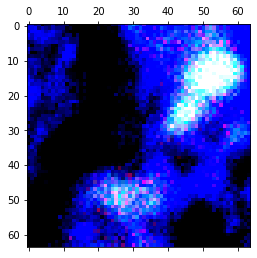

In [7]:
plt.matshow(all_dict['pics'][0][:,:,:3])

In [8]:
thr_list = [0.1 * i for i in range(9, 0, -1)]

In [9]:
stat_df = []
for thr in thr_list:
    stat_df.append(pd.DataFrame(detect_clusters(all_dict, thr, main_cat='planck_z'), 
                                index=[0]))
stat_df = pd.concat(stat_df)

In [10]:
stat_df

,tp,fp,tn,fn
0,4,4,1608,36
0,11,12,1536,29
0,17,20,1449,23
0,24,33,1352,16
0,25,42,1281,15
0,26,48,1236,14
0,27,60,1182,13
0,31,94,1084,9
0,40,994,446,0


In [11]:
stat_df_all = []
for thr in thr_list:
    stat_df_all.append(pd.DataFrame(detect_clusters(all_dict, thr, main_cat='all'), 
                                index=[0]))
stat_df_all = pd.concat(stat_df_all)

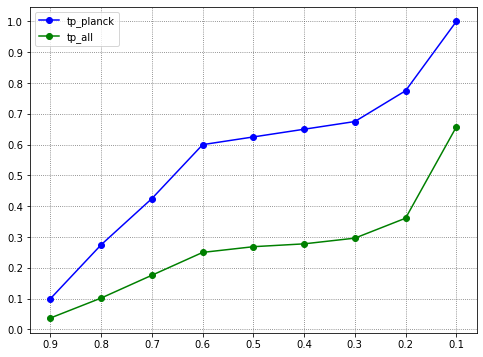

In [14]:
draw_df(None, {'tp_planck' : stat_df['tp'] / (stat_df['tp'] + stat_df['fn']), 
               'tp_all' : stat_df_all['tp'] / (stat_df_all['tp'] + stat_df_all['fn'])},
        thr_list, ygrid=np.arange(0,1.1, 0.1))

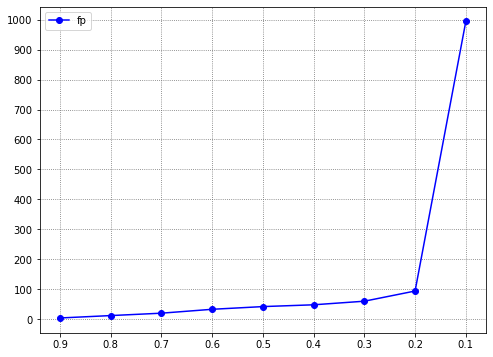

In [17]:
draw_df(None, {'fp':stat_df_all['fp']},
        thr_list, ygrid=np.arange(0,1100,100))